# Group Project for CVPR-UIC
#### Author: FENG Ziao Auberon 2030025036

input image shape: torch.Size([375, 500, 3])
output image shape: torch.Size([750, 1000, 3])


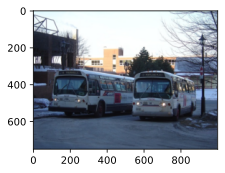

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


# Implementation of bilinear kernel
# Three parameters: input channels, output channels and kernel size
def bilinear_kernel(in_channels, out_channels, kernel_size):
    # calculate the center of the kernel
    # Use // to maintain a integer factor
    factor = (kernel_size + 1) // 2
    # divide the even and odd size
    if kernel_size % 2 == 1:
        center = factor - 1
    # even size is middle center
    else:
        center = factor - 0.5
    # create a matrix with center size
    og = (torch.arange(kernel_size).reshape(-1,1),
         torch.arange(kernel_size).reshape(1,-1))
    # linear reduce the weight of filter
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)    
    # weight matrix defination
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))  
    # assign the weights
    weight[range(in_channels),range(out_channels),:,:] = filt
    return weight


# experiment for upsampling
conv_trans = nn.ConvTranspose2d(3,3,kernel_size=4,padding=1,stride=2,bias=False)  

conv_trans.weight.data.copy_(bilinear_kernel(3,3,4))

img = torchvision.transforms.ToTensor()(d2l.Image.open('2007_001595.jpg'))

X = img.unsqueeze(0)

Y = conv_trans(X)

out_img = Y[0].permute(1,2,0).detach()

d2l.set_figsize()

print('input image shape:', img.permute(1,2,0).shape)

d2l.plt.imshow(img.permute(1,2,0))

print('output image shape:',out_img.shape)

d2l.plt.imshow(out_img)





In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet


# Define the EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=21)
# model.extract_features
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=21)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [3]:
num_classes = 21
class CustomEfficientNet(nn.Module):
    def __init__(self, efficientnet_model, num_classes):
        super(CustomEfficientNet, self).__init__()
        # EfficientNet for feature extraction part
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=21)
        # self.efficientnet = nn.Sequential(*list(model.children())[:-4])
        self.final_conv = nn.Conv2d(1280, num_classes, kernel_size=1)
        self.transpose_conv =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32)
    
    def forward(self, x):
        # features
        x = self.efficientnet.extract_features(x)
        # print(x.shape)
        x = self.final_conv(x)
        x = self.transpose_conv(x)
        return x

custom_model = CustomEfficientNet(efficientnet_model, num_classes)

Loaded pretrained weights for efficientnet-b0


custom_model.add_module('final_conv',nn.Conv2d(1280, num_classes, kernel_size=1)) 
custom_model.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))

In [5]:
X = torch.rand(size=(1,3,320,480))
res = custom_model(X)
print(res.shape)

torch.Size([1, 21, 320, 480])


In [6]:


# initialize using bilinear weight
# num_classes is class number(target number)，kernel size is 64
W = bilinear_kernel(num_classes, num_classes, 64)
# set transpose layer's weight
custom_model.transpose_conv.weight.data.copy_(W)
# load dataset
batch_size, crop_size = 32, (320,480)
# two used data loader
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.388, train acc 0.886, test acc 0.873
3.1 examples/sec on [device(type='cpu')]


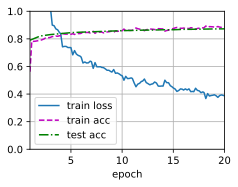

In [5]:
# train

def loss(inputs, targets):

    # .mean(1).mean(1) each width and height mean
    # print(inputs.shape)
    # print(targets.shape)
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)    

# Use CPU to train
num_epochs, lr, wd, devices = 20, 0.001, 1e-3, [d2l.cpu()]
# SGD OPTIMIZER
trainer = torch.optim.SGD(custom_model.parameters(), lr=lr, weight_decay=wd)


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# custom_model.to(device)
# custom_model.train()

# training
d2l.train_ch13(custom_model, train_iter, test_iter, loss, trainer, num_epochs, devices) 


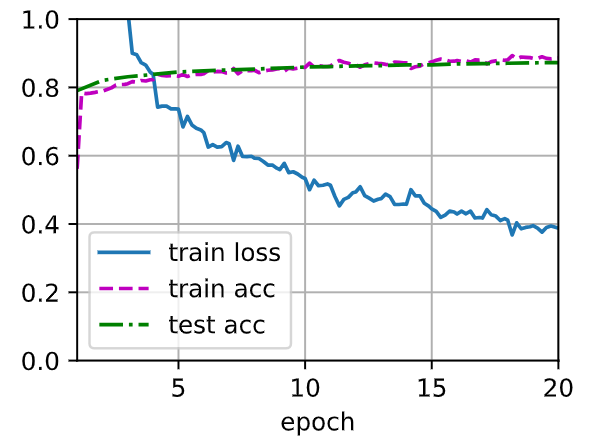

In [7]:

def predict(img):
    # normalize_image normalize the pixel of image
    # unsqueeze(0) add a new dimention
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)

    pred = custom_model(X.to(devices[0])).argmax(dim=1) # argmax to get the labels
    return pred.reshape(pred.shape[1],pred.shape[2]) # reshape to the same size of the image

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

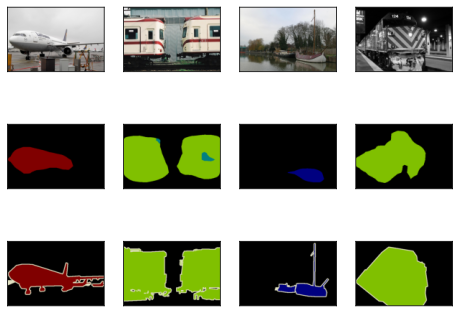

In [8]:
# visualize prediction
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    
    X = pred.long()
    
    return colormap[X,:]

voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')

test_images, test_labels = d2l.read_voc_images(voc_dir, False)

n, imgs = 4, []

for i in range(n):
    
    crop_rect = (0,0,320,480)
    
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)  
    
    pred = label2image(predict(X)) 

    imgs += [X.permute(1,2,0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1,2,0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3],3,n,scale=2) # line2 prediction and line3 target

In [9]:
torch.save(custom_model.state_dict(), 'EfficientFCN_epoch_20.pth')

## Try to predict UIC-collected data

Loaded pretrained weights for efficientnet-b0


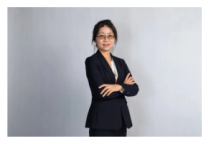

In [16]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn

model = CustomEfficientNet(efficientnet_model, num_classes)
model.load_state_dict(torch.load('EfficientFCN_epoch_20.pth'))
image_path = 'test2.jpg'
image = Image.open(image_path)

# Define data preprocessing transformations for input images
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation transformations (e.g., random horizontal and vertical flipping)
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

input = image_transform(image).unsqueeze(0)
plt.imshow(image)
output = model(input)
prediction = output.argmax(dim=1).squeeze().cpu()
# plt.imshow(prediction)
plt.axis('off')
plt.show()

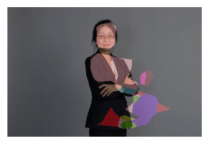

In [17]:
import numpy as np

# Define the colormap
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    indices = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((indices >> channel) & 1) << shift
        indices >>= 3

    return colormap

# Apply this colormap to label
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

# Get color mask from prediction
color_mask = label_to_color_image(prediction.numpy())
color_mask = Image.fromarray(color_mask.astype('uint8'))

# Opacity factor for the overlay
alpha = 0.5

# Convert the original image to a PIL image if needed
if not isinstance(image, Image.Image):
    image = F.to_pil_image(image)

# First, resize the prediction mask to the original image size
original_size = image.size  # Assuming `image` is a PIL image and has the original size
# Resize color_mask to match the original image size
color_mask = color_mask.resize(original_size, resample=Image.NEAREST)

# Ensure both images are in the same mode
if image.mode != 'RGB':
    image = image.convert('RGB')
if color_mask.mode != 'RGB':
    color_mask = color_mask.convert('RGB')

# Now blend them
combined_img = Image.blend(image, color_mask, alpha)
# Overlay the color mask on the original image
combined_img = Image.blend(image, color_mask, alpha)

# Display the combined image
plt.imshow(combined_img)
plt.axis('off')
plt.show()

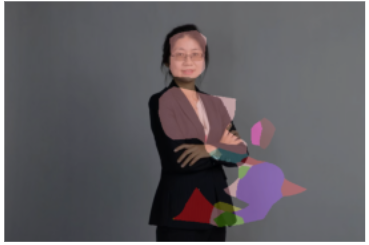

Loaded pretrained weights for efficientnet-b0


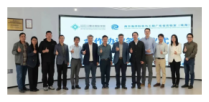

In [60]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn

model = CustomEfficientNet(efficientnet_model, num_classes)
model.load_state_dict(torch.load('EfficientFCN_epoch_20.pth'))
image_path = 'test1.jpg'
image = Image.open(image_path)

# Define data preprocessing transformations for input images
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation transformations (e.g., random horizontal and vertical flipping)
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

input = image_transform(image).unsqueeze(0)
plt.imshow(image)

# plt.imshow(prediction)
plt.axis('off')
plt.show()

In [61]:
output = model(input)
prediction = output.argmax(dim=1).squeeze().cpu()

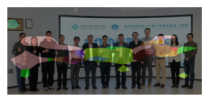

In [62]:
import numpy as np

# Define the colormap
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    indices = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((indices >> channel) & 1) << shift
        indices >>= 3

    return colormap

# Apply this colormap to label
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

# Get color mask from prediction
color_mask = label_to_color_image(prediction.numpy())
color_mask = Image.fromarray(color_mask.astype('uint8'))

# Opacity factor for the overlay
alpha = 0.5

# Convert the original image to a PIL image if needed
if not isinstance(image, Image.Image):
    image = F.to_pil_image(image)

# First, resize the prediction mask to the original image size
original_size = image.size  # Assuming `image` is a PIL image and has the original size
# Resize color_mask to match the original image size
color_mask = color_mask.resize(original_size, resample=Image.NEAREST)

# Ensure both images are in the same mode
if image.mode != 'RGB':
    image = image.convert('RGB')
if color_mask.mode != 'RGB':
    color_mask = color_mask.convert('RGB')

# Now blend them
combined_img = Image.blend(image, color_mask, alpha)
# Overlay the color mask on the original image
combined_img = Image.blend(image, color_mask, alpha)

# Display the combined image
plt.imshow(combined_img)
plt.axis('off')
plt.show()

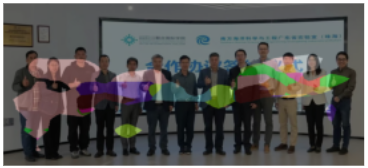

## Try MODEL Evaluation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation transformations (e.g., random horizontal and vertical flipping)
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

val_dataset = VOCSegmentation(root='./data/', year='2012', image_set='val', download=True,transform = image_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data/


In [ ]:
model = CustomEfficientNet(efficientnet_model, num_classes)
model.load_state_dict(torch.load('EfficientFCN_epoch_20.pth'))
# Evaluate the model on the validation dataset
model.eval()
predictions = []
targets = []

for images, labels in test_iter:
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

# Calculate mIoU
intersection = torch.logical_and(torch.tensor(predictions), torch.tensor(targets)).sum()
union = torch.logical_or(torch.tensor(predictions), torch.tensor(targets)).sum()
mIoU = intersection / union
print('mIoU:', mIoU.item())

# Unused codes for future management
# Try Efficient backnone
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

class FCN_OLD(nn.Module):
    def __init__(self, num_classes):
        super(FCN_OLD, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.conv6 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv7 = nn.Conv2d(256, num_classes, kernel_size=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.relu(self.conv5(x))
        x = self.upsample(x)   # First upsample
        x = self.relu(self.conv6(x))
        x = self.upsample(x)   # Second upsample
        x = self.upsample(x)   # Third upsample
        x = self.upsample(x)   # Fourth upsample, now x should have the same HxW as the input
        
        x = self.conv7(x)      # Final convolution to get to the number of classes
        return x





import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn

# Define a transform for the target mask
def target_transform(mask):
    mask = transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST)(mask)
    mask = transforms.PILToTensor()(mask)  # Convert directly to tensor without normalizing
    mask = mask.squeeze().long()  # Remove color channel and convert to long type
    return mask

# Define data preprocessing transformations for input images
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation transformations (e.g., random horizontal and vertical flipping)
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

# Load the PASCAL VOC 2012 dataset with the custom target transform
train_dataset = VOCSegmentation(root='./data/', year='2012', image_set='train', download=True, transform=image_transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='./data/', year='2012', image_set='val', download=True, transform=image_transform, target_transform=target_transform)

# Create collate_fn to handle padding
def collate_fn(batch):
    images, masks = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

model = FCN_OLD(num_classes=150)
if torch.cuda.is_available():
    model = model.cuda()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 在验证集上评估模型
    model.eval()
    total = 0
    correct = 0
    for images, labels in val_loader:
        # Move images and labels to CPU
        images = images.cpu()
        labels = labels.cpu()

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Epoch: {}, Accuracy: {}%'.format(epoch+1, accuracy))

torch.save(model.state_dict(), 'model.pth')



############################################
# Load the saved model
model = FCN_OLD(num_classes=150)
model.load_state_dict(torch.load('model.pth'))

import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

image_path = '2007_001595.jpg'
image = Image.open(image_path)
input = image_transform(image).unsqueeze(0)
plt.imshow(image)
output = model(input)
prediction = output.argmax(dim=1).squeeze().cpu()
# plt.imshow(prediction)
plt.axis('off')
plt.show()

import numpy as np

# Define the colormap
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    indices = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((indices >> channel) & 1) << shift
        indices >>= 3

    return colormap

# Apply this colormap to label
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

# Get color mask from prediction
color_mask = label_to_color_image(prediction.numpy())
color_mask = Image.fromarray(color_mask.astype('uint8'))

# Opacity factor for the overlay
alpha = 0.8

# Convert the original image to a PIL image if needed
if not isinstance(image, Image.Image):
    image = F.to_pil_image(image)

# First, resize the prediction mask to the original image size
original_size = image.size  # Assuming `image` is a PIL image and has the original size
# Resize color_mask to match the original image size
color_mask = color_mask.resize(original_size, resample=Image.NEAREST)

# Ensure both images are in the same mode
if image.mode != 'RGB':
    image = image.convert('RGB')
if color_mask.mode != 'RGB':
    color_mask = color_mask.convert('RGB')

# Now blend them
combined_img = Image.blend(image, color_mask, alpha)
# Overlay the color mask on the original image
combined_img = Image.blend(image, color_mask, alpha)

# Display the combined image
plt.imshow(combined_img)
plt.axis('off')
plt.show()


# 定义转换
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 加载ADE20K训练集和验证集
train_dataset = ADE20K(root='path_to_dataset', split='training', transform=transform)
val_dataset = ADE20K(root='path_to_dataset', split='validation', transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 初始化模型
model = FCN(num_classes=150)
if torch.cuda.is_available():
    model = model.cuda()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 在验证集上评估模型
    model.eval()
    total = 0
    correct = 0
    for images, labels in val_loader:
        if torch.cuda.is_available():
            images = images.cuda()

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()

    accuracy = 100 * correct / total
    print('Epoch: {}, Accuracy: {}%'.format(epoch+1, accuracy))



import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
# Define data preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Add data augmentation transformations (e.g., random horizontal and vertical flipping)
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])


def custom_collate(batch):
    images = []
    labels = []
    for img, lbl in batch:
        images.append(torch.Tensor(img))
        labels.append(torch.Tensor([lbl]))

    return torch.stack(images), torch.stack(labels)

# Load the PASCAL VOC 2012 dataset
dataset = VOCSegmentation(root='./data/', year='2012', image_set='train', download=True,transform = transform)


val_dataset = VOCSegmentation(root='./data/', year='2012', image_set='val', download=True,transform = transform)

# Apply preprocessing transformations to the dataset
# dataset = dataset.transform(transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# val_dataset = val_dataset.transform(transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

'''
# Define the data loader
def create_data_loader(root, split, transform, batch_size, shuffle=True):
    dataset = VOCSegmentation(root=root, year='2012', image_set=split, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader
# Create the training data loader
dataloader = create_data_loader(root='./data/', split='train', transform=transform, batch_size=32)

# Create the validation data loader
val_loader = create_data_loader(root='./data/', split='val', transform=transform, batch_size=32)
'''

train_dataloader =  DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)

import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

# Define the EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=21)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Train the efficient model
for epoch in range(30):
    for images, labels in train_dataloader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Define the FCN model with EfficientNet as a feature extractor
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0', include_top=False)
        self.decoder = nn.Sequential(
            nn.Conv2d(1280, 256, kernel_size=1),
            nn.ConvTranspose2d(256, num_classes, kernel_size=16, stride=8, padding=4)
        )

    def forward(self, x):
        features = self.encoder.extract_features(x)
        output = self.decoder(features)
        return output

# Create the FCN model
model = FCN(num_classes=21)

# Freeze the parameters of the EfficientNet backbone
for param in model.encoder.parameters():
    param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(30):
    for images, labels in dataloader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model on the validation dataset
model.eval()
predictions = []
targets = []

for images, labels in validation_dataloader:
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        targets.extend(labels.tolist())

# Calculate mIoU
intersection = torch.logical_and(torch.tensor(predictions), torch.tensor(targets)).sum()
union = torch.logical_or(torch.tensor(predictions), torch.tensor(targets)).sum()
mIoU = intersection / union
print('mIoU:', mIoU.item())